In [1]:
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [4]:
data = pd.read_csv('./data/low_temp_overall.csv')
data.head()

,"gas_feed temperature, C","gas_feed pressure, kPa","gas_feed mass flow, kg/h",gas_feed molecular weight,"gas_feed Mass density, kg/m3","gas_feed actual liquid flow, m3/h","gas_feed actual vapour flow, m3/h",gas_feed mass heat capacity,gas_feed Methane mass frac,gas_feed Ethane mass frac,...,"17 actual liquid flow, m3/h","17 actual vapour flow, m3/h",17 mass heat capacity,17 Methane mass frac,17 Ethane mass frac,17 Propane mass frac,17 i-Butane mass frac,17 n-Butane mass frac,17 i-Pentane mass frac,17 n-Pentane mass frac
0,-23.0,4041.0,21277.0,23.956971,73.393036,18.015246,271.889646,2.552841,0.508804,0.071252,...,16.473024,0.671735,2.248443,0.055855,0.065350,0.159964,0.362796,0.318673,0.009351,0.028012
1,-11.0,4320.0,6634.0,28.122865,103.408737,7.785243,56.367944,2.562291,0.358629,0.128836,...,7.471808,0.002190,3.172211,0.000006,0.092802,0.051350,0.424403,0.380461,0.026824,0.024153
2,9.0,4299.0,22552.0,27.218717,79.662664,20.458362,262.635360,2.574080,0.375699,0.151103,...,18.949131,0.423676,2.593380,0.022762,0.091335,0.049298,0.296327,0.511004,0.008935,0.020340
3,-15.0,4214.0,9679.0,23.387540,70.663424,6.863007,130.110260,2.640162,0.498093,0.158571,...,6.564201,0.000000,3.120212,0.000004,0.117264,0.232341,0.524567,0.045849,0.047009,0.032967
4,-15.0,3757.0,7193.0,19.586848,42.874012,1.841248,165.929382,2.504826,0.740581,0.022713,...,2.215091,0.131402,2.214229,0.048311,0.015410,0.058774,0.532420,0.216966,0.099379,0.028739


In [5]:
## Рассчитываем массовые расходы отдельных компонентов
data.loc[:, 'gas_feed Methane mass flow, kg/h'] = data['gas_feed mass flow, kg/h'] * data['gas_feed Methane mass frac']
data.loc[:, 'gas_feed Ethane mass flow, kg/h'] = data['gas_feed mass flow, kg/h'] * data['gas_feed Ethane mass frac']
data.loc[:, 'gas_feed Propane mass flow, kg/h'] = data['gas_feed mass flow, kg/h'] * data['gas_feed Propane mass frac']
data.loc[:, 'gas_feed i-Butane mass flow, kg/h'] = data['gas_feed mass flow, kg/h'] * data['gas_feed i-Butane mass frac']
data.loc[:, 'gas_feed n-Butane mass flow, kg/h'] = data['gas_feed mass flow, kg/h'] * data['gas_feed n-Butane mass frac']
data.loc[:, 'gas_feed i-Pentane mass flow, kg/h'] = data['gas_feed mass flow, kg/h'] * data['gas_feed i-Pentane mass frac']
data.loc[:, 'gas_feed n-Pentane mass flow, kg/h'] = data['gas_feed mass flow, kg/h'] * data['gas_feed n-Pentane mass frac']

data.loc[:, '1 Methane mass flow, kg/h'] = data['1 mass flow, kg/h'] * data['1 Methane mass frac']
data.loc[:, '1 Ethane mass flow, kg/h'] = data['1 mass flow, kg/h'] * data['1 Ethane mass frac']
data.loc[:, '1 Propane mass flow, kg/h'] = data['1 mass flow, kg/h'] * data['1 Propane mass frac']
data.loc[:, '1 i-Butane mass flow, kg/h'] = data['1 mass flow, kg/h'] * data['1 i-Butane mass frac']
data.loc[:, '1 n-Butane mass flow, kg/h'] = data['1 mass flow, kg/h'] * data['1 n-Butane mass frac']
data.loc[:, '1 i-Pentane mass flow, kg/h'] = data['1 mass flow, kg/h'] * data['1 i-Pentane mass frac']
data.loc[:, '1 n-Pentane mass flow, kg/h'] = data['1 mass flow, kg/h'] * data['1 n-Pentane mass frac']

## Определение объемных расходов пара и жидкости сырьевого потока

In [3]:
feed_prod_vol_flow = data[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac','gas_feed n-Pentane mass frac',
]]

In [4]:
feed_prod_vol_flow.describe()

,"gas_feed temperature, C","gas_feed pressure, kPa","gas_feed mass flow, kg/h","gas_feed actual liquid flow, m3/h","gas_feed actual vapour flow, m3/h",gas_feed Methane mass frac,gas_feed Ethane mass frac,gas_feed Propane mass frac,gas_feed i-Butane mass frac,gas_feed n-Butane mass frac,gas_feed i-Pentane mass frac,gas_feed n-Pentane mass frac
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,17513.410166,13.334570,236.913322,0.477853,0.123608,0.071424,0.143099,0.163792,0.010122,0.010102
std,10.266356,403.397921,7206.613928,7.586198,119.499390,0.080848,0.050958,0.030397,0.064333,0.086969,0.004279,0.004274
min,-25.000000,3500.000000,5000.000000,0.000000,21.448718,0.267349,0.010872,0.014322,0.021081,0.002458,0.002234,0.002290
25%,-17.000000,3860.000000,11290.000000,7.247971,141.562427,0.419732,0.086266,0.046392,0.089873,0.091571,0.006606,0.006578
50%,-9.000000,4211.000000,17518.000000,12.151037,220.801211,0.472422,0.126887,0.070418,0.143815,0.168010,0.009864,0.009854
75%,0.000000,4557.000000,23750.000000,18.383058,313.726759,0.530387,0.160727,0.093634,0.192630,0.235017,0.013161,0.013138
max,10.000000,4900.000000,30000.000000,46.708568,862.437275,0.853544,0.322328,0.221481,0.379844,0.428366,0.032362,0.030832


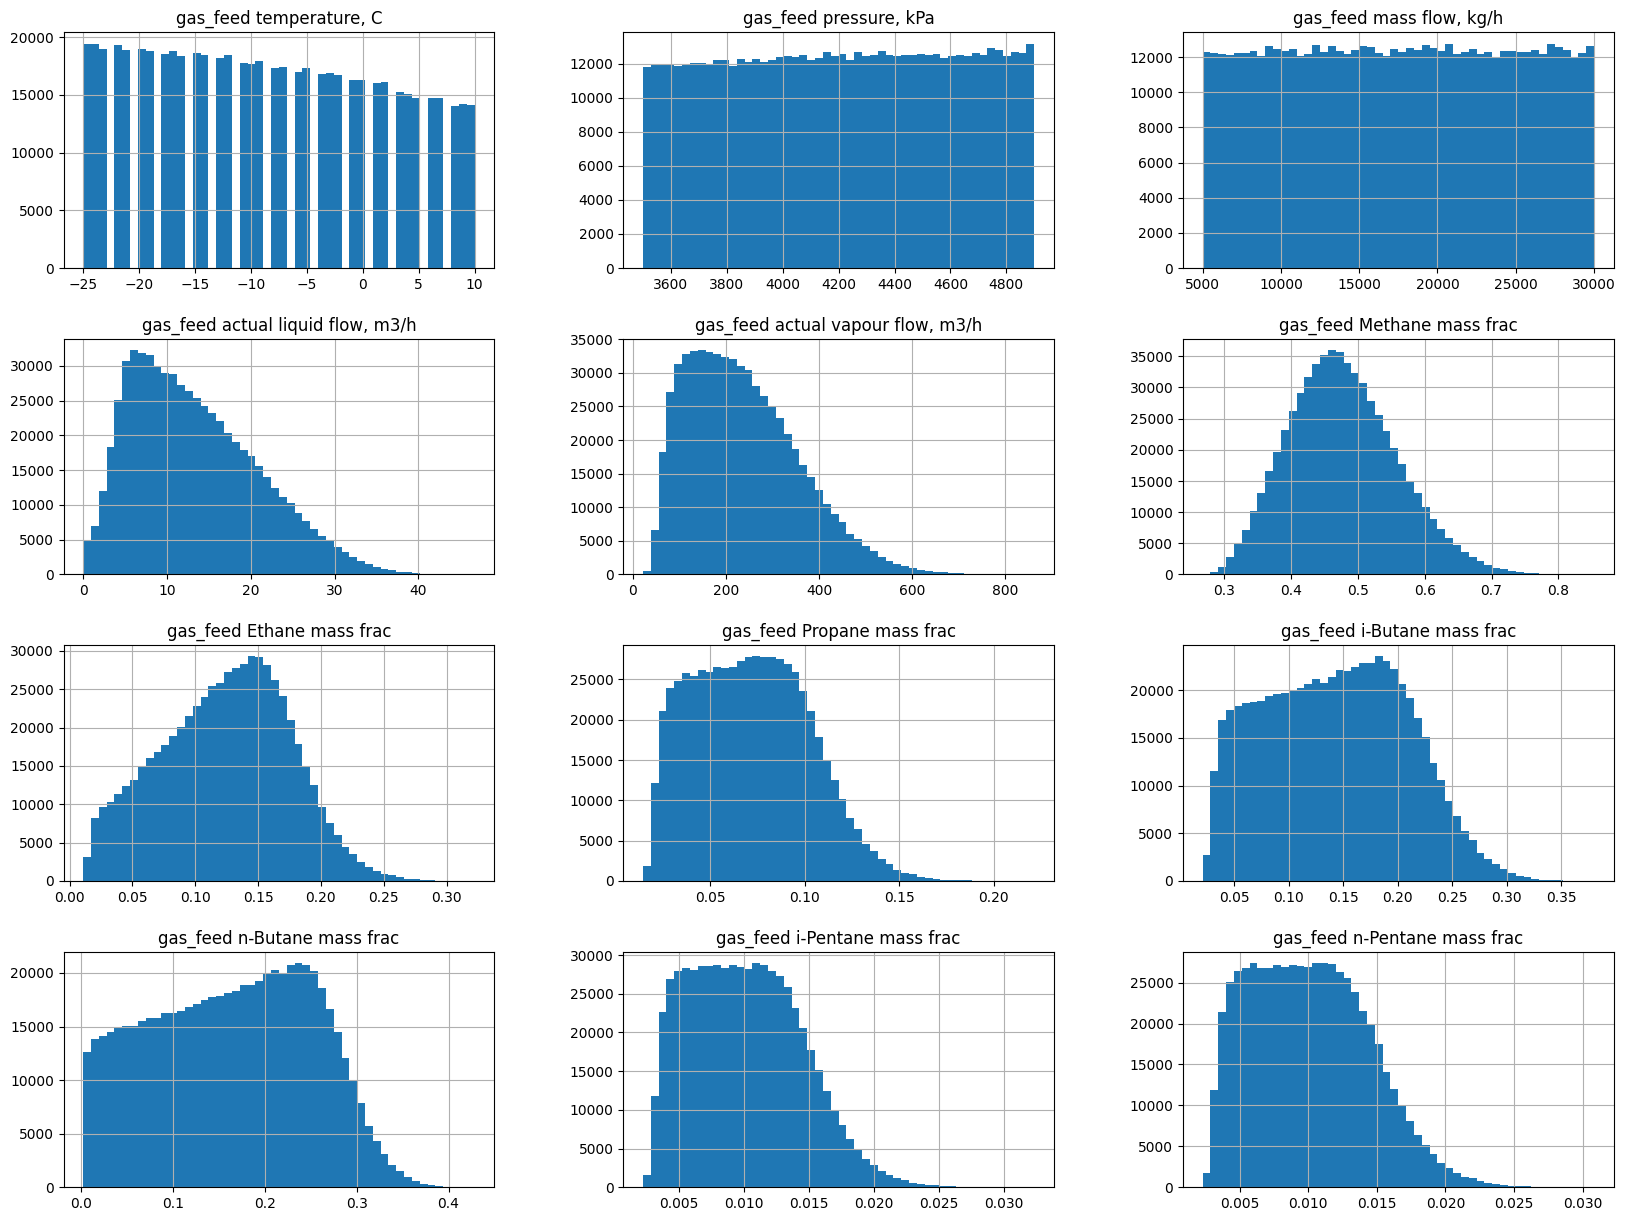

In [5]:
feed_prod_vol_flow.hist(bins=50, figsize=(20, 15));

In [6]:
corr_matrix = feed_prod_vol_flow.corr()

corr_matrix['gas_feed actual liquid flow, m3/h'].sort_values(ascending=False)

gas_feed actual liquid flow, m3/h    1.000000
gas_feed mass flow, kg/h             0.723261
gas_feed n-Butane mass frac          0.397954
gas_feed actual vapour flow, m3/h    0.225261
gas_feed i-Butane mass frac          0.214191
gas_feed pressure, kPa               0.093939
gas_feed Propane mass frac          -0.009964
gas_feed Ethane mass frac           -0.058984
gas_feed i-Pentane mass frac        -0.087376
gas_feed n-Pentane mass frac        -0.090083
gas_feed temperature, C             -0.238838
gas_feed Methane mass frac          -0.548213
Name: gas_feed actual liquid flow, m3/h, dtype: float64

In [7]:
## Тестовая и обучающая выборки
X = feed_prod_vol_flow[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed Methane mass frac',
    'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac','gas_feed n-Pentane mass frac',
]]

y = feed_prod_vol_flow[[
    'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h'
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed Methane mass frac',
    'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac','gas_feed n-Pentane mass frac',
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 10), (494360, 2))

In [8]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
feed_prod_vol_flow_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(2)
])

# 2. Compile the model
feed_prod_vol_flow_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
feed_prod_vol_flow_model.fit(X_train_normal, y_train, epochs=40)

Epoch 1/40
15449/15449 [==============================] - 31s 2ms/step - loss: 2.2094 - mae: 2.2094
Epoch 2/40
15449/15449 [==============================] - 33s 2ms/step - loss: 0.9969 - mae: 0.9969
Epoch 3/40
15449/15449 [==============================] - 32s 2ms/step - loss: 0.8725 - mae: 0.8725
Epoch 4/40
15449/15449 [==============================] - 50s 3ms/step - loss: 0.7854 - mae: 0.7854
Epoch 5/40
15449/15449 [==============================] - 39s 2ms/step - loss: 0.7297 - mae: 0.7297
Epoch 6/40
15449/15449 [==============================] - 34s 2ms/step - loss: 0.6990 - mae: 0.6990
Epoch 7/40
15449/15449 [==============================] - 34s 2ms/step - loss: 0.6505 - mae: 0.6505
Epoch 8/40
15449/15449 [==============================] - 33s 2ms/step - loss: 0.6296 - mae: 0.6296
Epoch 9/40
15449/15449 [==============================] - 36s 2ms/step - loss: 0.5921 - mae: 0.5921
Epoch 10/40
15449/15449 [==============================] - 41s 3ms/step - loss: 0.5677 - mae: 0.5677

In [9]:
y_pred = feed_prod_vol_flow_model.predict(X_test_normal)

3863/3863 [==============================] - 5s 1ms/step


In [10]:
x = 156
pred = y_pred[x]
pred

array([  6.8597426, 349.4037   ], dtype=float32)

In [11]:
test = y_test.iloc[x]
test

gas_feed actual liquid flow, m3/h      6.926595
gas_feed actual vapour flow, m3/h    348.885917
Name: 30381, dtype: float64

In [13]:
feed_prod_vol_flow_model.save('./models/low_temp_dist_24_04/feed_prod_vol_flow_model.h5')

## Определение массовых расходов продуктов сепаратора

In [15]:
sep_prod_mass_flow = data[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac',
    '1 mass flow, kg/h', '2 mass flow, kg/h'
]]

In [16]:
sep_prod_mass_flow.describe()

,"gas_feed temperature, C","gas_feed pressure, kPa","gas_feed mass flow, kg/h","gas_feed actual liquid flow, m3/h","gas_feed actual vapour flow, m3/h",gas_feed Methane mass frac,gas_feed Ethane mass frac,gas_feed Propane mass frac,gas_feed i-Butane mass frac,gas_feed n-Butane mass frac,gas_feed i-Pentane mass frac,gas_feed n-Pentane mass frac,"1 mass flow, kg/h","2 mass flow, kg/h"
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,17513.410166,13.334570,236.913322,0.477853,0.123608,0.071424,0.143099,0.163792,0.010122,0.010102,10708.440240,6804.969926
std,10.266356,403.397921,7206.613928,7.586198,119.499390,0.080848,0.050958,0.030397,0.064333,0.086969,0.004279,0.004274,5156.225297,3873.795315
min,-25.000000,3500.000000,5000.000000,0.000000,21.448718,0.267349,0.010872,0.014322,0.021081,0.002458,0.002234,0.002290,1178.371232,0.000000
25%,-17.000000,3860.000000,11290.000000,7.247971,141.562427,0.419732,0.086266,0.046392,0.089873,0.091571,0.006606,0.006578,6520.828264,3691.914667
50%,-9.000000,4211.000000,17518.000000,12.151037,220.801211,0.472422,0.126887,0.070418,0.143815,0.168010,0.009864,0.009854,10148.332833,6192.395464
75%,0.000000,4557.000000,23750.000000,18.383058,313.726759,0.530387,0.160727,0.093634,0.192630,0.235017,0.013161,0.013138,14193.118168,9389.228804
max,10.000000,4900.000000,30000.000000,46.708568,862.437275,0.853544,0.322328,0.221481,0.379844,0.428366,0.032362,0.030832,29970.000000,23148.669181


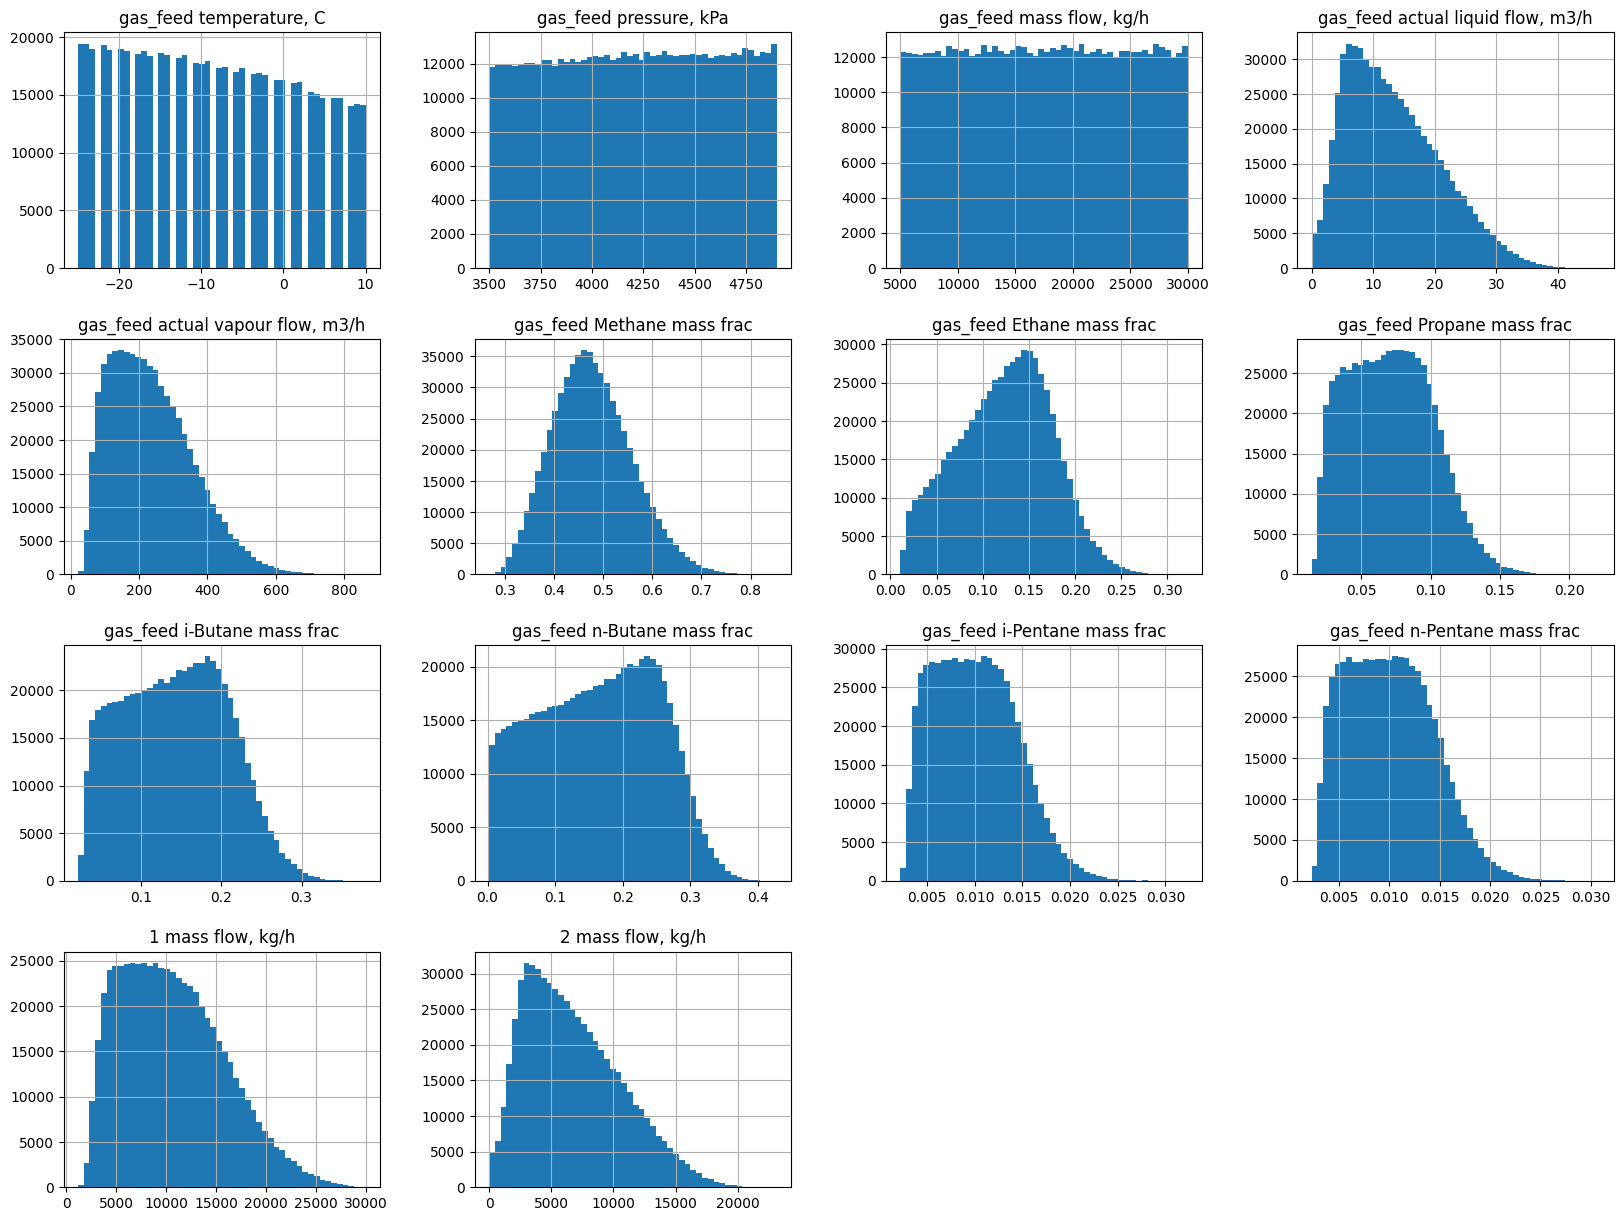

In [17]:
sep_prod_mass_flow.hist(bins=50, figsize=(20, 15));

In [18]:
corr_matrix = sep_prod_mass_flow.corr()

corr_matrix['1 mass flow, kg/h'].sort_values(ascending=False)

1 mass flow, kg/h                    1.000000
gas_feed actual vapour flow, m3/h    0.964563
gas_feed mass flow, kg/h             0.854649
gas_feed Methane mass frac           0.404069
gas_feed actual liquid flow, m3/h    0.260942
2 mass flow, kg/h                    0.258893
gas_feed temperature, C              0.187186
gas_feed Ethane mass frac            0.072754
gas_feed i-Pentane mass frac         0.064500
gas_feed n-Pentane mass frac         0.061846
gas_feed Propane mass frac           0.015669
gas_feed pressure, kPa              -0.045402
gas_feed i-Butane mass frac         -0.155920
gas_feed n-Butane mass frac         -0.314609
Name: 1 mass flow, kg/h, dtype: float64

In [28]:
## Тестовая и обучающая выборки
X = sep_prod_mass_flow[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac',
]]

y = sep_prod_mass_flow[['1 mass flow, kg/h']]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac',
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 12), (494360, 1))

In [29]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
sep_prod_mass_flow_model = tf.keras.Sequential([
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
sep_prod_mass_flow_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
sep_prod_mass_flow_model.fit(X_train_normal, y_train, epochs=50)

Epoch 1/50
15449/15449 [==============================] - 24s 2ms/step - loss: 288.8892 - mae: 288.8892
Epoch 2/50
15449/15449 [==============================] - 23s 2ms/step - loss: 53.8112 - mae: 53.8112
Epoch 3/50
15449/15449 [==============================] - 25s 2ms/step - loss: 41.1446 - mae: 41.1446
Epoch 4/50
15449/15449 [==============================] - 25s 2ms/step - loss: 34.6084 - mae: 34.6084
Epoch 5/50
15449/15449 [==============================] - 25s 2ms/step - loss: 31.2063 - mae: 31.2063
Epoch 6/50
15449/15449 [==============================] - 25s 2ms/step - loss: 29.9441 - mae: 29.9441
Epoch 7/50
15449/15449 [==============================] - 26s 2ms/step - loss: 29.0855 - mae: 29.0855
Epoch 8/50
15449/15449 [==============================] - 26s 2ms/step - loss: 28.4967 - mae: 28.4967
Epoch 9/50
15449/15449 [==============================] - 28s 2ms/step - loss: 28.0549 - mae: 28.0549
Epoch 10/50
15449/15449 [==============================] - 30s 2ms/step - loss: 

In [30]:
y_pred = sep_prod_mass_flow_model.predict(X_test_normal)

3863/3863 [==============================] - 5s 1ms/step


In [39]:
x = 678
pred = y_pred[x]
pred

array([16290.109], dtype=float32)

In [40]:
test = y_test.iloc[x]
test

1 mass flow, kg/h    16269.813575
Name: 526689, dtype: float64

In [41]:
sum(pred)

16290.109375

In [43]:
sep_prod_mass_flow_model.save('./models/low_temp_dist_24_04/sep_prod_mass_flow_model.h5')

## Определение состава продуктов сепаратора

In [15]:
sep_prod_comp = data[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac', 'gas_feed Methane mass flow, kg/h',
    'gas_feed Ethane mass flow, kg/h', 'gas_feed Propane mass flow, kg/h', 'gas_feed i-Butane mass flow, kg/h',
    'gas_feed n-Butane mass flow, kg/h', 'gas_feed i-Pentane mass flow, kg/h', 'gas_feed n-Pentane mass flow, kg/h',
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h',
    '1 Methane mass flow, kg/h', '1 Ethane mass flow, kg/h', '1 Propane mass flow, kg/h', '1 i-Butane mass flow, kg/h',
    '1 n-Butane mass flow, kg/h', '1 i-Pentane mass flow, kg/h', '1 n-Pentane mass flow, kg/h'
]]

In [16]:
# sep_prod_comp_sample = sep_prod_comp.sample(frac=0.7)

In [17]:
sep_prod_comp.describe()

,"gas_feed temperature, C","gas_feed pressure, kPa","gas_feed mass flow, kg/h","gas_feed actual liquid flow, m3/h","gas_feed actual vapour flow, m3/h",gas_feed Methane mass frac,gas_feed Ethane mass frac,gas_feed Propane mass frac,gas_feed i-Butane mass frac,gas_feed n-Butane mass frac,...,"1 temperature, C","1 pressure, kPa","1 mass flow, kg/h","1 Methane mass flow, kg/h","1 Ethane mass flow, kg/h","1 Propane mass flow, kg/h","1 i-Butane mass flow, kg/h","1 n-Butane mass flow, kg/h","1 i-Pentane mass flow, kg/h","1 n-Pentane mass flow, kg/h"
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,...,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,17513.410166,13.334570,236.913322,0.477853,0.123608,0.071424,0.143099,0.163792,...,-8.480579,4207.666418,10708.440240,7632.388741,1460.298519,517.565783,589.143102,471.614328,20.746357,16.683410
std,10.266356,403.397921,7206.613928,7.586198,119.499390,0.080848,0.050958,0.030397,0.064333,0.086969,...,10.266356,403.397921,5156.225297,3614.775361,990.738355,424.436118,502.295492,384.349698,29.766231,26.292927
min,-25.000000,3500.000000,5000.000000,0.000000,21.448718,0.267349,0.010872,0.014322,0.021081,0.002458,...,-25.000000,3500.000000,1178.371232,880.888195,29.271809,14.877799,8.414354,1.505019,0.210124,0.177216
25%,-17.000000,3860.000000,11290.000000,7.247971,141.562427,0.419732,0.086266,0.046392,0.089873,0.091571,...,-17.000000,3860.000000,6520.828264,4687.393010,704.857361,222.580618,241.889471,196.335571,5.721252,4.311031
50%,-9.000000,4211.000000,17518.000000,12.151037,220.801211,0.472422,0.126887,0.070418,0.143815,0.168010,...,-9.000000,4211.000000,10148.332833,7276.421479,1233.954705,395.241341,439.921803,364.488321,11.569586,8.797048
75%,0.000000,4557.000000,23750.000000,18.383058,313.726759,0.530387,0.160727,0.093634,0.192630,0.235017,...,0.000000,4557.000000,14193.118168,10119.317074,1990.463164,678.562980,772.651250,633.447974,23.585255,18.377524
max,10.000000,4900.000000,30000.000000,46.708568,862.437275,0.853544,0.322328,0.221481,0.379844,0.428366,...,10.000000,4900.000000,29970.000000,23882.854503,8210.145468,5160.041992,5662.226921,3388.108050,675.411675,591.001933


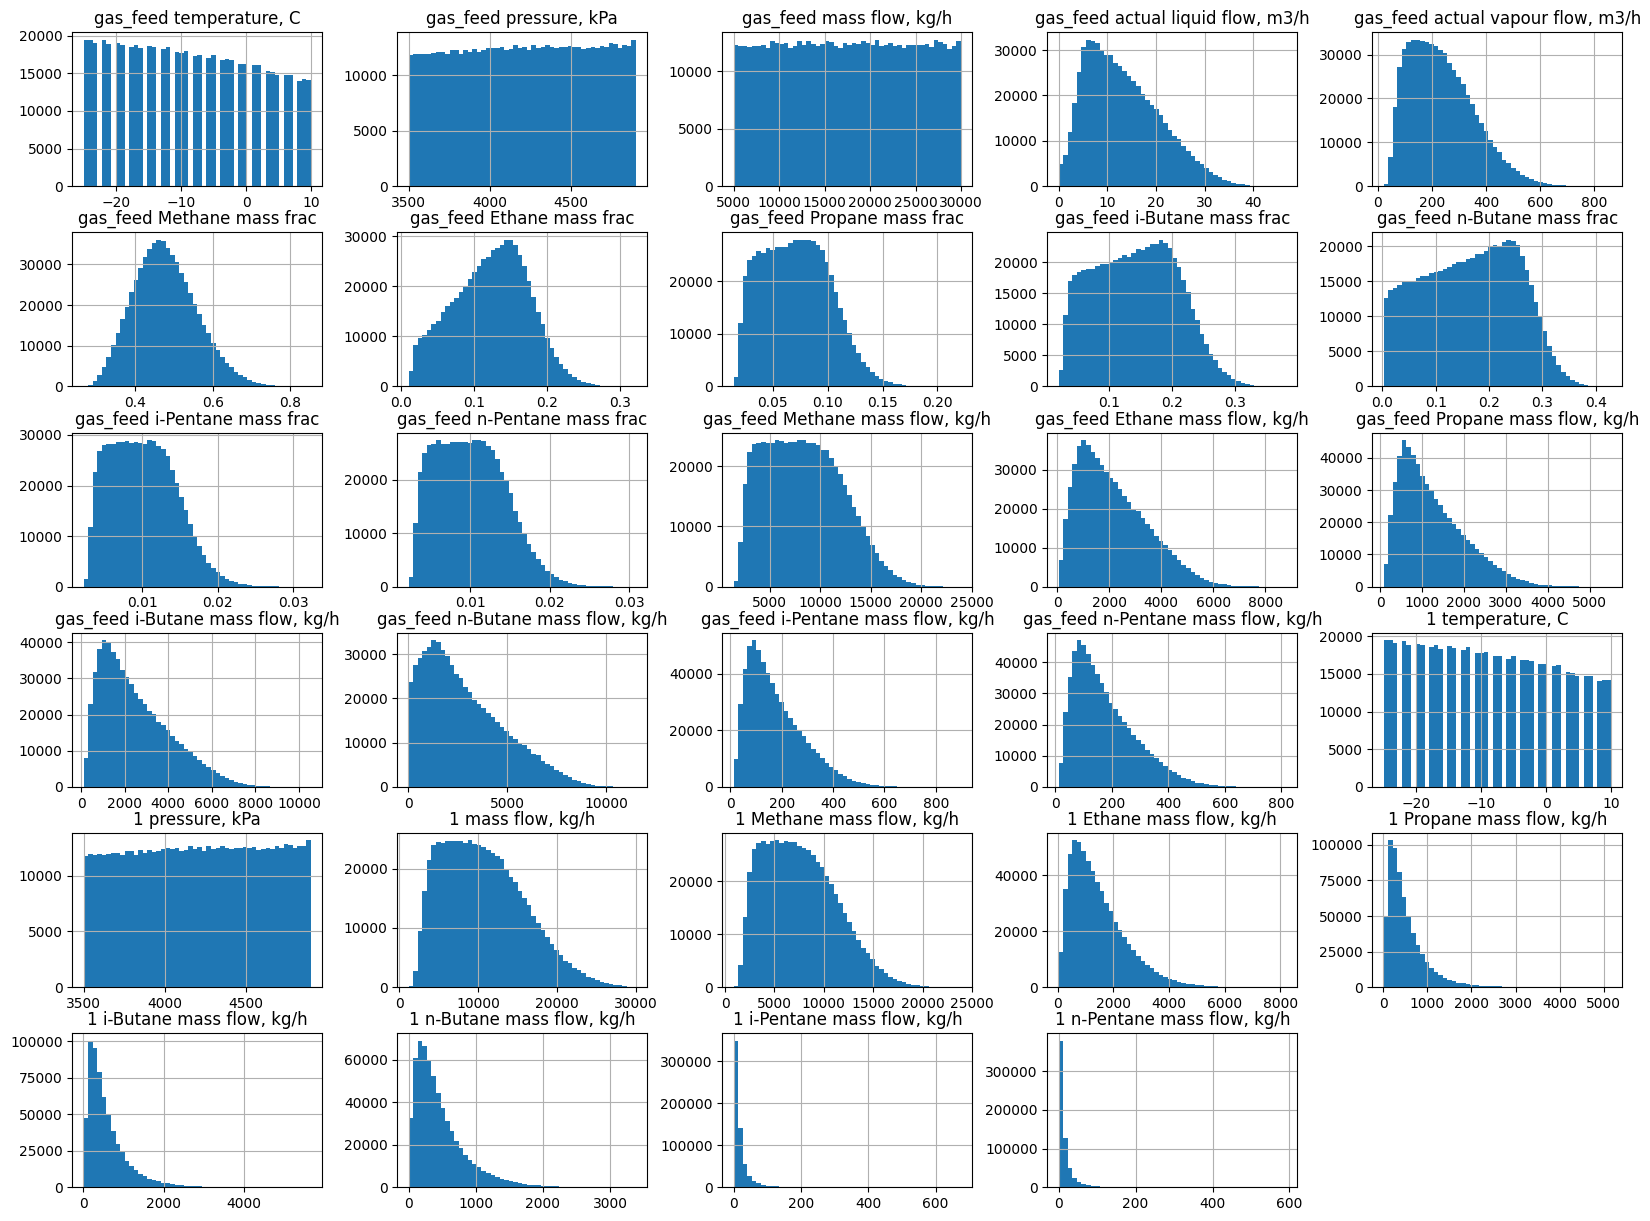

In [18]:
sep_prod_comp.hist(bins=50, figsize=(20, 15));

In [19]:
corr_matrix = sep_prod_comp.corr()

corr_matrix['1 Methane mass flow, kg/h'].sort_values(ascending=False)

1 Methane mass flow, kg/h             1.000000
gas_feed Methane mass flow, kg/h      0.992623
1 mass flow, kg/h                     0.975638
gas_feed actual vapour flow, m3/h     0.945467
gas_feed mass flow, kg/h              0.868608
1 Propane mass flow, kg/h             0.658732
gas_feed i-Pentane mass flow, kg/h    0.635667
gas_feed n-Pentane mass flow, kg/h    0.634248
1 Ethane mass flow, kg/h              0.620798
1 i-Butane mass flow, kg/h            0.596967
gas_feed Propane mass flow, kg/h      0.574703
gas_feed Ethane mass flow, kg/h       0.534483
1 i-Pentane mass flow, kg/h           0.518957
1 n-Butane mass flow, kg/h            0.502327
1 n-Pentane mass flow, kg/h           0.487702
gas_feed Methane mass frac            0.451633
gas_feed i-Butane mass flow, kg/h     0.435488
gas_feed actual liquid flow, m3/h     0.313278
gas_feed n-Butane mass flow, kg/h     0.265541
gas_feed i-Pentane mass frac          0.067116
gas_feed n-Pentane mass frac          0.064797
gas_feed temp

In [20]:
## Тестовая и обучающая выборки
X = sep_prod_comp[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac', 'gas_feed Methane mass flow, kg/h',
    'gas_feed Ethane mass flow, kg/h', 'gas_feed Propane mass flow, kg/h', 'gas_feed i-Butane mass flow, kg/h',
    'gas_feed n-Butane mass flow, kg/h', 'gas_feed i-Pentane mass flow, kg/h', 'gas_feed n-Pentane mass flow, kg/h',
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h',
]]

y = sep_prod_comp[[
    '1 Methane mass flow, kg/h', '1 Ethane mass flow, kg/h', '1 Propane mass flow, kg/h', '1 i-Butane mass flow, kg/h',
    '1 n-Butane mass flow, kg/h', '1 i-Pentane mass flow, kg/h', '1 n-Pentane mass flow, kg/h'
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac', 'gas_feed Methane mass flow, kg/h',
    'gas_feed Ethane mass flow, kg/h', 'gas_feed Propane mass flow, kg/h', 'gas_feed i-Butane mass flow, kg/h',
    'gas_feed n-Butane mass flow, kg/h', 'gas_feed i-Pentane mass flow, kg/h', 'gas_feed n-Pentane mass flow, kg/h',
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h',
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 22), (494360, 7))

In [21]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
sep_top_prod_comp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(22, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(7)
])

# 2. Compile the model
sep_top_prod_comp_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
sep_top_prod_comp_model.fit(X_train_normal, y_train, epochs=50)

Epoch 1/50
15449/15449 [==============================] - 33s 2ms/step - loss: 158.4568 - mae: 158.4568
Epoch 2/50
15449/15449 [==============================] - 33s 2ms/step - loss: 63.5656 - mae: 63.5656
Epoch 3/50
15449/15449 [==============================] - 34s 2ms/step - loss: 18.7423 - mae: 18.7423
Epoch 4/50
15449/15449 [==============================] - 37s 2ms/step - loss: 15.7730 - mae: 15.7730
Epoch 5/50
15449/15449 [==============================] - 36s 2ms/step - loss: 14.2374 - mae: 14.2374
Epoch 6/50
15449/15449 [==============================] - 36s 2ms/step - loss: 13.2169 - mae: 13.2169
Epoch 7/50
15449/15449 [==============================] - 33s 2ms/step - loss: 12.4242 - mae: 12.4242
Epoch 8/50
15449/15449 [==============================] - 35s 2ms/step - loss: 11.6810 - mae: 11.6810
Epoch 9/50
15449/15449 [==============================] - 34s 2ms/step - loss: 10.7335 - mae: 10.7335
Epoch 10/50
15449/15449 [==============================] - 34s 2ms/step - loss: 

In [22]:
y_pred = sep_top_prod_comp_model.predict(X_test_normal)

3863/3863 [==============================] - 5s 922us/step


In [51]:
x = 895
pred = y_pred[x]
list(pred)

[10654.608, 2629.2659, 815.09894, 737.9021, 415.4418, 85.968956, 35.686207]

In [52]:
test = y_test.iloc[x]
test

1 Methane mass flow, kg/h      10641.301187
1 Ethane mass flow, kg/h        2640.757075
1 Propane mass flow, kg/h        813.089767
1 i-Butane mass flow, kg/h       751.438902
1 n-Butane mass flow, kg/h       413.195106
1 i-Pentane mass flow, kg/h       82.868358
1 n-Pentane mass flow, kg/h       37.537710
Name: 284960, dtype: float64

In [53]:
sum(list(test.values))

15380.188105736208

In [54]:
sum(list(pred))

15373.972270965576

In [55]:
sum(list(test.values)) - sum(list(pred))

6.215834770631773

In [56]:
list(list(pred) / sum(list(pred)))

[0.693029,
 0.17102058,
 0.053018108,
 0.04799684,
 0.02702241,
 0.0055918503,
 0.0023212093]

In [57]:
list(list(test.values) / sum(list(test.values)))

[0.6918836827182948,
 0.17169862012162115,
 0.05286604829176431,
 0.04885758853274871,
 0.026865413053724706,
 0.0053879937999977015,
 0.002440653481848601]

In [58]:
sep_top_prod_comp_model.save('./models/low_temp_dist_24_04/sep_top_prod_comp_model.h5')

## Определение температуры газа после детандера

In [60]:
expander_gas_temp_data = data[[
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h', '1 Methane mass frac', '1 Ethane mass frac',
    '1 Propane mass frac', '1 i-Butane mass frac', '1 n-Butane mass frac', '1 i-Pentane mass frac', '1 n-Pentane mass frac',
    '3 temperature, C', '3 pressure, kPa'
]]

In [61]:
expander_gas_temp_data.describe()

,"1 temperature, C","1 pressure, kPa","1 mass flow, kg/h",1 Methane mass frac,1 Ethane mass frac,1 Propane mass frac,1 i-Butane mass frac,1 n-Butane mass frac,1 i-Pentane mass frac,1 n-Pentane mass frac,"3 temperature, C","3 pressure, kPa"
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,10708.440240,0.718432,0.134965,0.046194,0.052959,0.044415,0.001691,0.001344,-31.102971,2299.671637
std,10.266356,403.397921,5156.225297,0.067038,0.054089,0.022804,0.029159,0.025668,0.001615,0.001423,11.950149,173.395338
min,-25.000000,3500.000000,1178.371232,0.486766,0.012521,0.006105,0.004229,0.000462,0.000115,0.000077,-61.649513,2000.000000
25%,-17.000000,3860.000000,6520.828264,0.670146,0.095429,0.028730,0.031357,0.025633,0.000742,0.000557,-40.574609,2149.000000
50%,-9.000000,4211.000000,10148.332833,0.720280,0.139257,0.042838,0.047637,0.040661,0.001222,0.000931,-31.355123,2300.000000
75%,0.000000,4557.000000,14193.118168,0.767161,0.175188,0.059833,0.069162,0.060084,0.002049,0.001602,-21.658693,2450.000000
max,10.000000,4900.000000,29970.000000,0.903853,0.325984,0.216986,0.215197,0.163427,0.025310,0.026572,-0.570558,2600.000000


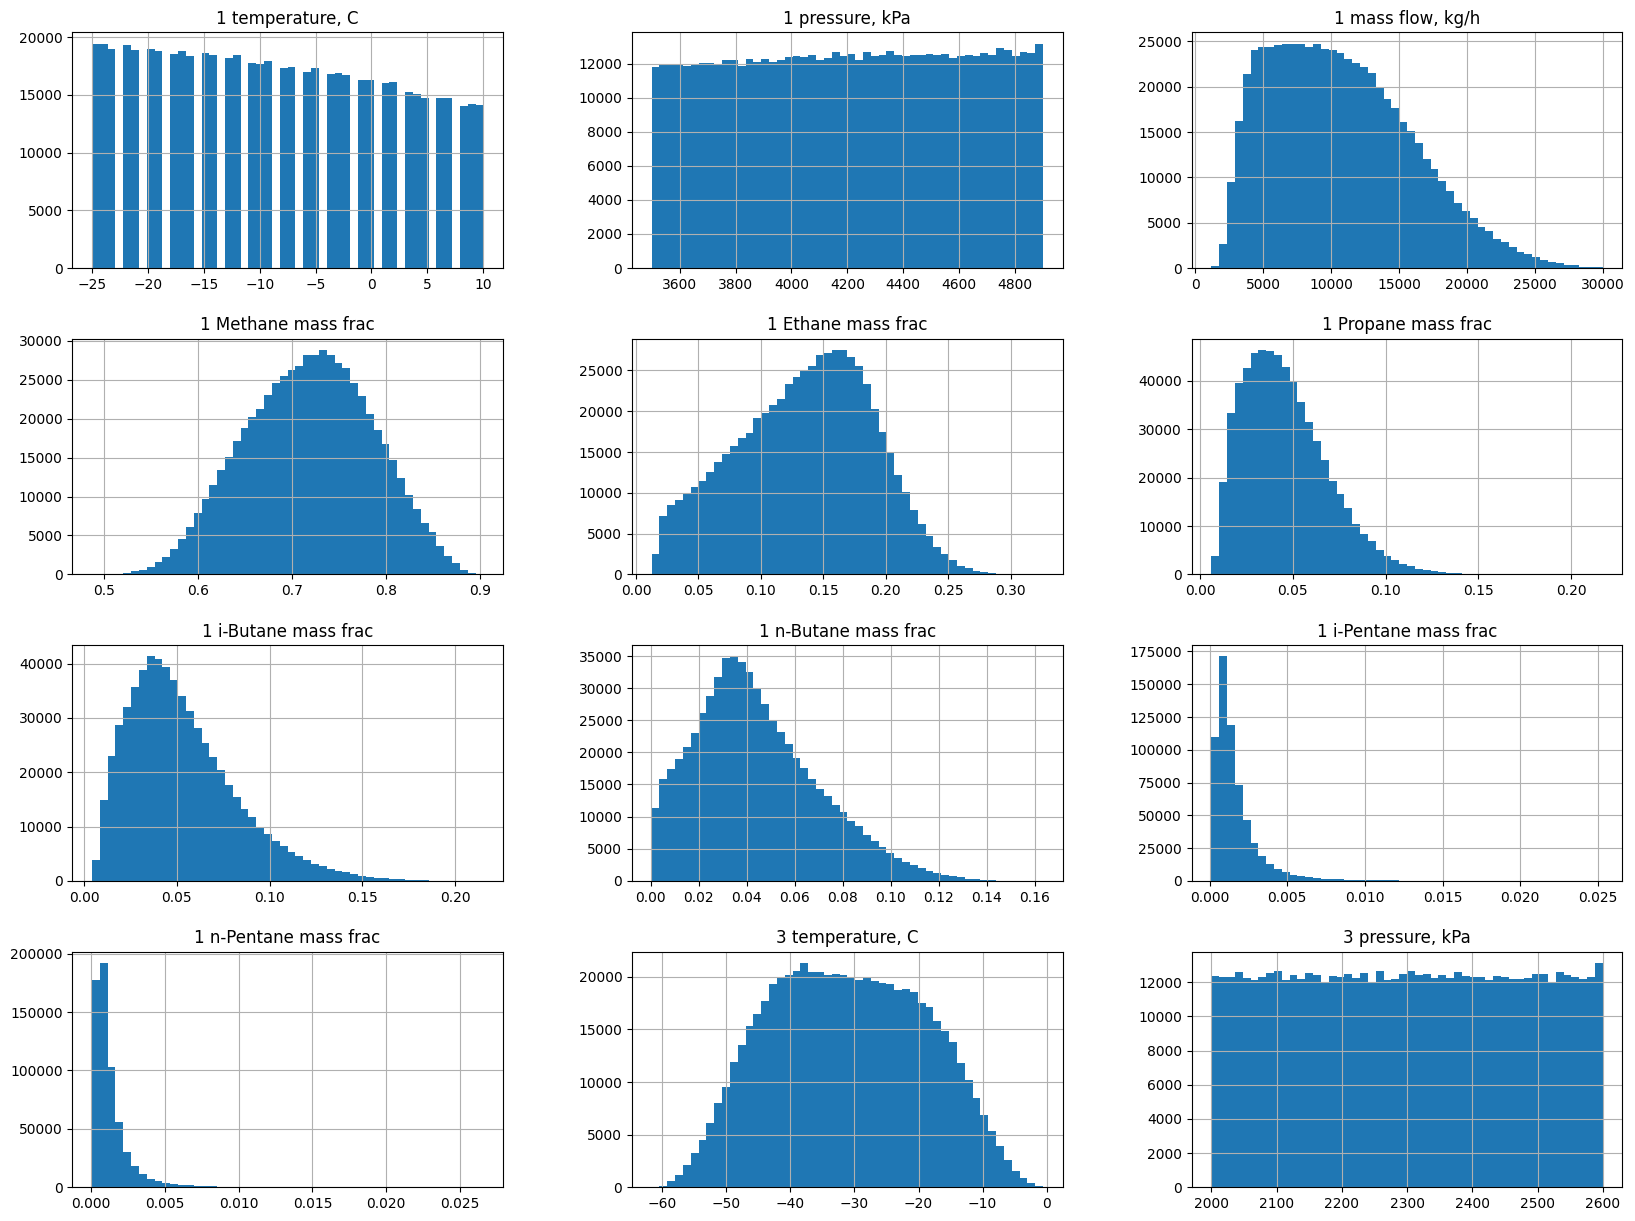

In [62]:
expander_gas_temp_data.hist(bins=50, figsize=(20, 15));

In [63]:
corr_matrix = expander_gas_temp_data.corr()

corr_matrix['3 temperature, C'].sort_values(ascending=False)

3 temperature, C         1.000000
1 temperature, C         0.919709
1 n-Butane mass frac     0.543180
1 i-Butane mass frac     0.526962
1 i-Pentane mass frac    0.429530
1 n-Pentane mass frac    0.419068
1 Propane mass frac      0.370986
3 pressure, kPa          0.219673
1 mass flow, kg/h        0.184937
1 Ethane mass frac       0.161731
1 pressure, kPa         -0.311847
1 Methane mass frac     -0.713120
Name: 3 temperature, C, dtype: float64

In [64]:
## Тестовая и обучающая выборки
X = expander_gas_temp_data[[
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h', '1 Methane mass frac', '1 Ethane mass frac',
    '1 Propane mass frac', '1 i-Butane mass frac', '1 n-Butane mass frac', '1 i-Pentane mass frac', '1 n-Pentane mass frac',
    '3 pressure, kPa'
]]

y = expander_gas_temp_data[[
    '3 temperature, C'
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h', '1 Methane mass frac', '1 Ethane mass frac',
    '1 Propane mass frac', '1 i-Butane mass frac', '1 n-Butane mass frac', '1 i-Pentane mass frac', '1 n-Pentane mass frac',
    '3 pressure, kPa'
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 11), (494360, 1))

In [65]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
expander_gas_temp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
expander_gas_temp_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
expander_gas_temp_model.fit(X_train_normal, y_train, epochs=10)

Epoch 1/10
15449/15449 [==============================] - 33s 2ms/step - loss: 0.4054 - mae: 0.4054
Epoch 2/10
15449/15449 [==============================] - 36s 2ms/step - loss: 0.2245 - mae: 0.2245
Epoch 3/10
15449/15449 [==============================] - 35s 2ms/step - loss: 0.1899 - mae: 0.1899
Epoch 4/10
15449/15449 [==============================] - 35s 2ms/step - loss: 0.1710 - mae: 0.1710
Epoch 5/10
15449/15449 [==============================] - 35s 2ms/step - loss: 0.1573 - mae: 0.1573
Epoch 6/10
15449/15449 [==============================] - 37s 2ms/step - loss: 0.1463 - mae: 0.1463
Epoch 7/10
15449/15449 [==============================] - 35s 2ms/step - loss: 0.1361 - mae: 0.1361
Epoch 8/10
15449/15449 [==============================] - 41s 3ms/step - loss: 0.1266 - mae: 0.1266
Epoch 9/10
15449/15449 [==============================] - 39s 3ms/step - loss: 0.1207 - mae: 0.1207
Epoch 10/10
15449/15449 [==============================] - 36s 2ms/step - loss: 0.1199 - mae: 0.1199

In [66]:
y_pred = expander_gas_temp_model.predict(X_test_normal)

3863/3863 [==============================] - 3s 871us/step


In [82]:
x = 4432
pred = y_pred[x]
pred[0]

-38.37216

In [83]:
test = y_test.iloc[x]
test['3 temperature, C']

-38.41353056529377

In [84]:
expander_gas_temp_model.save('./models/low_temp_dist_24_04/expander_gas_temp_model.h5')

## Определение мощности детандера

In [92]:
expander_power_data = data[[
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h', '1 Methane mass frac', '1 Ethane mass frac',
    '1 Propane mass frac', '1 i-Butane mass frac', '1 n-Butane mass frac', '1 i-Pentane mass frac', '1 n-Pentane mass frac',
    '3 temperature, C', '3 pressure, kPa', 'Q-100',
]]

In [93]:
expander_power_data.describe()

,"1 temperature, C","1 pressure, kPa","1 mass flow, kg/h",1 Methane mass frac,1 Ethane mass frac,1 Propane mass frac,1 i-Butane mass frac,1 n-Butane mass frac,1 i-Pentane mass frac,1 n-Pentane mass frac,"3 temperature, C","3 pressure, kPa",Q-100
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,10708.440240,0.718432,0.134965,0.046194,0.052959,0.044415,0.001691,0.001344,-31.102971,2299.671637,118.795067
std,10.266356,403.397921,5156.225297,0.067038,0.054089,0.022804,0.029159,0.025668,0.001615,0.001423,11.950149,173.395338,61.901726
min,-25.000000,3500.000000,1178.371232,0.486766,0.012521,0.006105,0.004229,0.000462,0.000115,0.000077,-61.649513,2000.000000,11.207512
25%,-17.000000,3860.000000,6520.828264,0.670146,0.095429,0.028730,0.031357,0.025633,0.000742,0.000557,-40.574609,2149.000000,69.919474
50%,-9.000000,4211.000000,10148.332833,0.720280,0.139257,0.042838,0.047637,0.040661,0.001222,0.000931,-31.355123,2300.000000,109.470860
75%,0.000000,4557.000000,14193.118168,0.767161,0.175188,0.059833,0.069162,0.060084,0.002049,0.001602,-21.658693,2450.000000,157.148003
max,10.000000,4900.000000,29970.000000,0.903853,0.325984,0.216986,0.215197,0.163427,0.025310,0.026572,-0.570558,2600.000000,476.244814


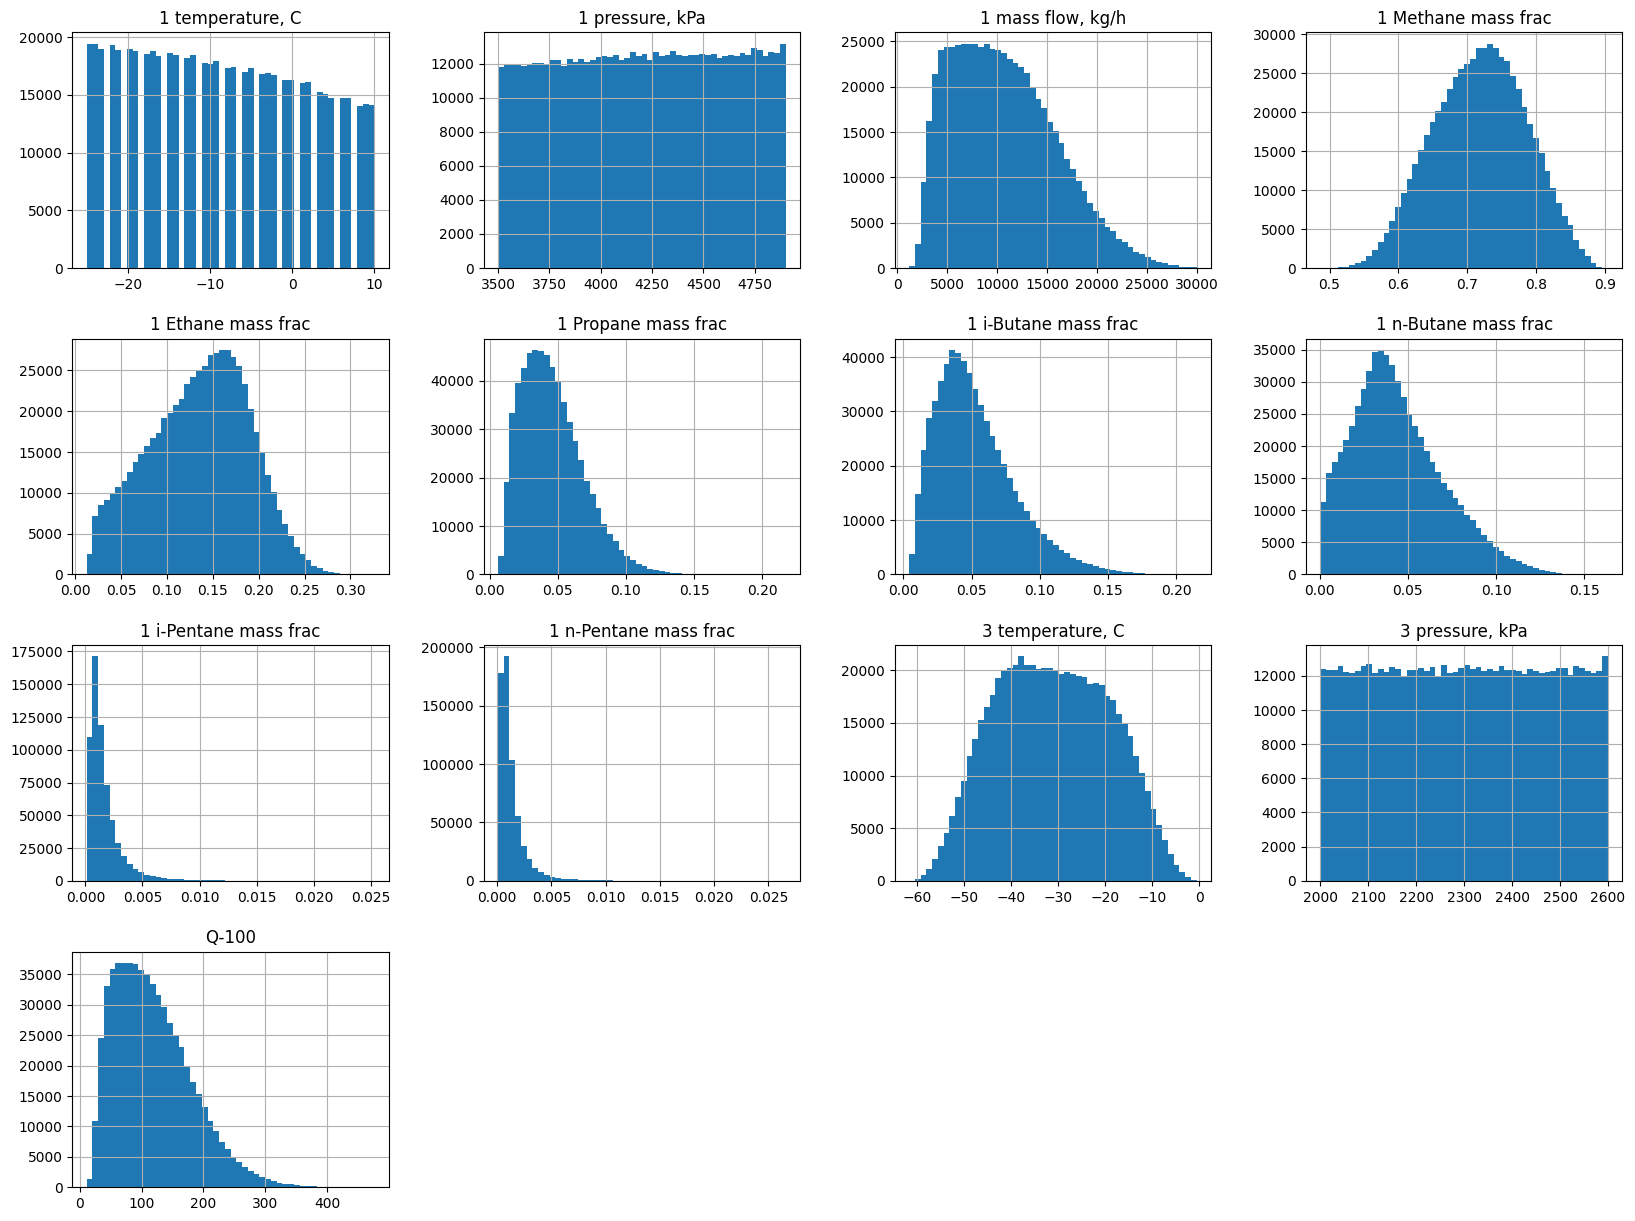

In [94]:
expander_power_data.hist(bins=50, figsize=(20, 15));

In [95]:
corr_matrix = expander_power_data.corr()

corr_matrix['Q-100'].sort_values(ascending=False)

Q-100                    1.000000
1 mass flow, kg/h        0.912382
1 i-Pentane mass frac    0.304179
1 n-Pentane mass frac    0.301533
1 pressure, kPa          0.229844
1 temperature, C         0.204798
1 Propane mass frac      0.162204
1 i-Butane mass frac     0.137107
3 temperature, C         0.060753
1 n-Butane mass frac     0.006101
1 Ethane mass frac      -0.023113
1 Methane mass frac     -0.112229
3 pressure, kPa         -0.235633
Name: Q-100, dtype: float64

In [96]:
## Тестовая и обучающая выборки
X = expander_power_data[[
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h', '1 Methane mass frac', '1 Ethane mass frac',
    '1 Propane mass frac', '1 i-Butane mass frac', '1 n-Butane mass frac', '1 i-Pentane mass frac', '1 n-Pentane mass frac',
    '3 temperature, C', '3 pressure, kPa'
]]

y = expander_power_data[[
    'Q-100'
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h', '1 Methane mass frac', '1 Ethane mass frac',
    '1 Propane mass frac', '1 i-Butane mass frac', '1 n-Butane mass frac', '1 i-Pentane mass frac', '1 n-Pentane mass frac',
    '3 temperature, C', '3 pressure, kPa'
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 12), (494360, 1))

In [97]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
expander_power_model = tf.keras.Sequential([
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
expander_power_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
expander_power_model.fit(X_train_normal, y_train, epochs=10)

Epoch 1/10
15449/15449 [==============================] - 32s 2ms/step - loss: 1.8433 - mae: 1.8433
Epoch 2/10
15449/15449 [==============================] - 39s 3ms/step - loss: 0.9714 - mae: 0.9714
Epoch 3/10
15449/15449 [==============================] - 35s 2ms/step - loss: 0.8441 - mae: 0.8441
Epoch 4/10
15449/15449 [==============================] - 35s 2ms/step - loss: 0.7716 - mae: 0.7716
Epoch 5/10
15449/15449 [==============================] - 36s 2ms/step - loss: 0.7051 - mae: 0.7051
Epoch 6/10
15449/15449 [==============================] - 36s 2ms/step - loss: 0.6567 - mae: 0.6567
Epoch 7/10
15449/15449 [==============================] - 35s 2ms/step - loss: 0.6155 - mae: 0.6155
Epoch 8/10
15449/15449 [==============================] - 36s 2ms/step - loss: 0.5959 - mae: 0.5959
Epoch 9/10
15449/15449 [==============================] - 36s 2ms/step - loss: 0.5655 - mae: 0.5655
Epoch 10/10
15449/15449 [==============================] - 34s 2ms/step - loss: 0.5390 - mae: 0.5390

In [98]:
y_pred = expander_power_model.predict(X_test_normal)

3863/3863 [==============================] - 4s 894us/step


In [110]:
x = 12356
pred = y_pred[x]
pred[0]

42.976284

In [111]:
test = y_test.iloc[x]
test['Q-100']

43.14102883744545

In [ ]:
expander_power_model.save('./models/low_temp_dist_24_04/expander_power_mod')